#Necessary Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

import sys
import string
import re
sys.path.append('../')

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
import nltk
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from xgboost import XGBClassifier


# Data Import

In [ ]:
# Drive files
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/dataset/training.1600000.processed.noemoticon.csv',engine='python', encoding='ISO-8859-1', names=['sentiment', 'id', 'date', 'query', 'user', 'text'])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data  Analysis

Check the Basic Info in Dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   query      1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df.columns

Index(['sentiment', 'id', 'date', 'query', 'user', 'text'], dtype='object')

In [ ]:
df.shape

(1600000, 6)

In [ ]:
np.sum(df.isnull().any(axis=1))

0

Plot to check users who tweet the most

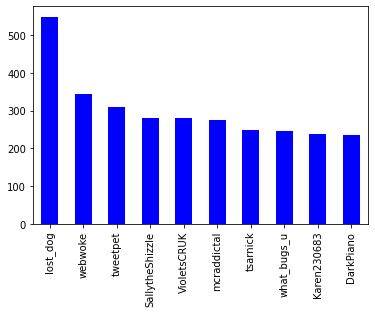

In [ ]:
users = df['user'].value_counts()[:10]
users.plot(kind='bar', color='blue')

Info of the data based on their polarity

The Negative tweets 800000
The positive tweets 800000


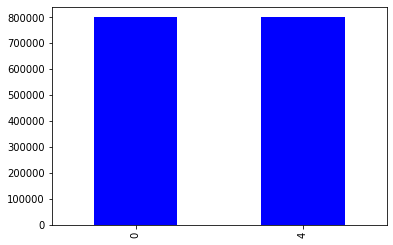

In [ ]:
x = df.sentiment.value_counts()
print('The Negative tweets',x[0])
print('The positive tweets', x[4])
x = df.sentiment.value_counts()
x.plot(kind='bar', color = 'blue')

Info on data based on lenfth of tweets(text column)

In [ ]:
text_len = df['text'].str.len()
txt_mean = text_len.mean()
txt_max = text_len.max()
txt_min = text_len.min()
print("Mean length of the tweets is:",txt_mean)
print("Max length of the tweets is:",txt_max)
print("Min length of the tweets is:",txt_min)

Mean length of the tweets is: 74.09011125
Max length of the tweets is: 374
Min length of the tweets is: 6


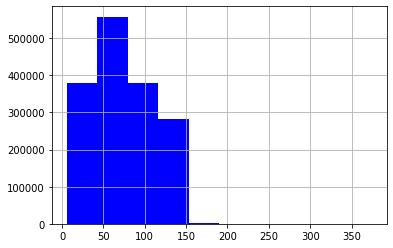

In [ ]:
df['text'].str.len().hist(color = 'blue')

Wordcloud Generation of most frequent words 

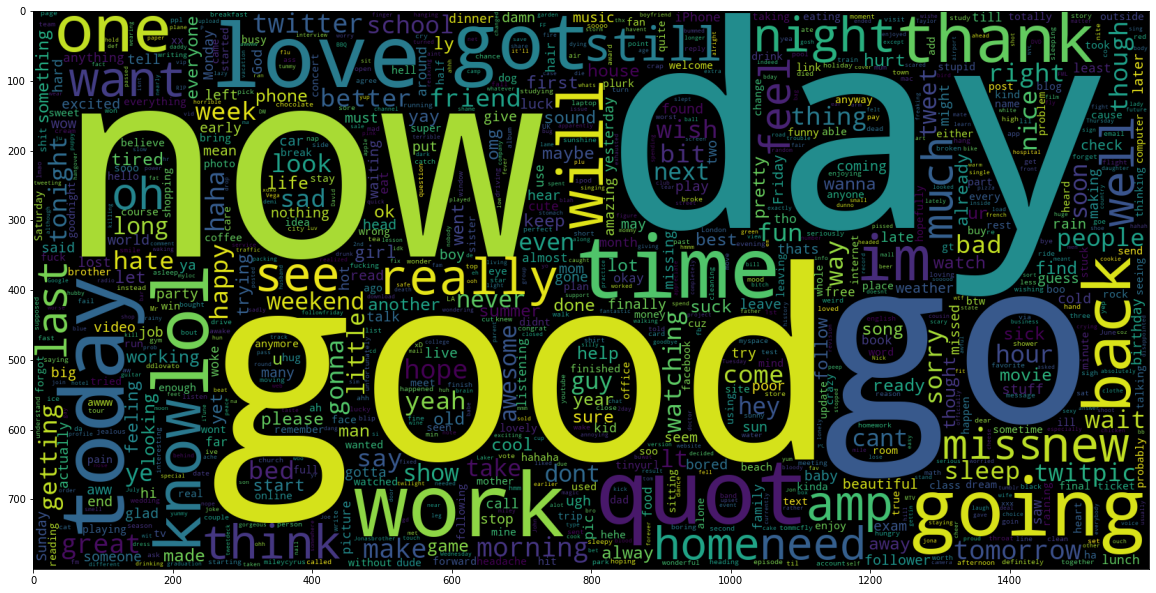

In [ ]:
# Wordcloud on complete data
X = df.text.copy()
y = df.sentiment.copy()
data_neg = X
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

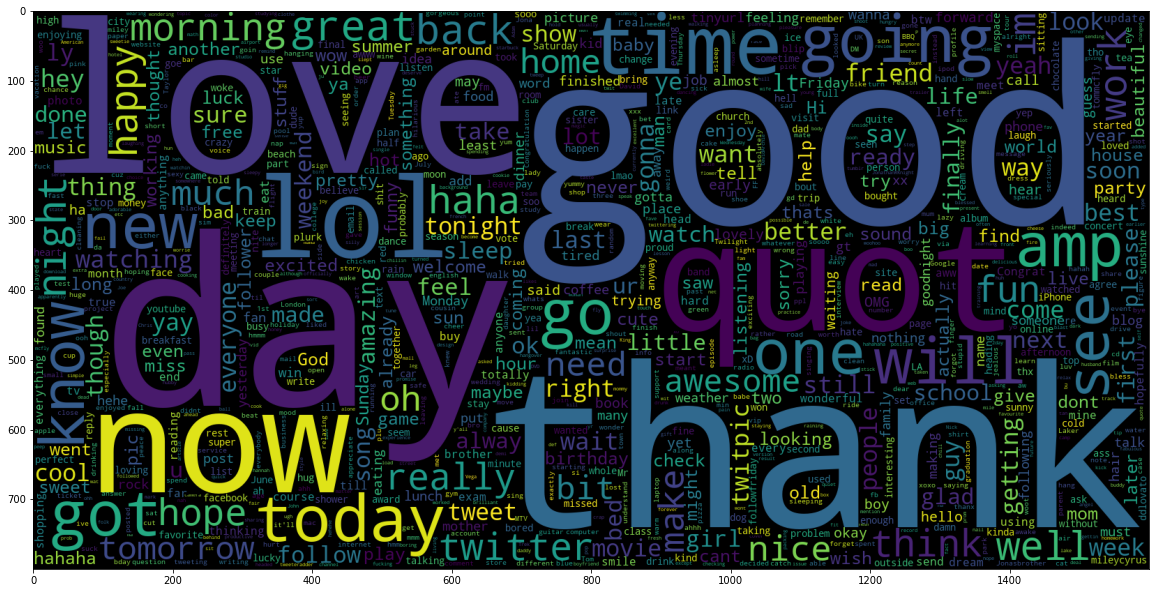

In [ ]:
# Wordcloud on positive data
X = df.text.copy()
y = df.sentiment.copy()
data_neg = X[y==4]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

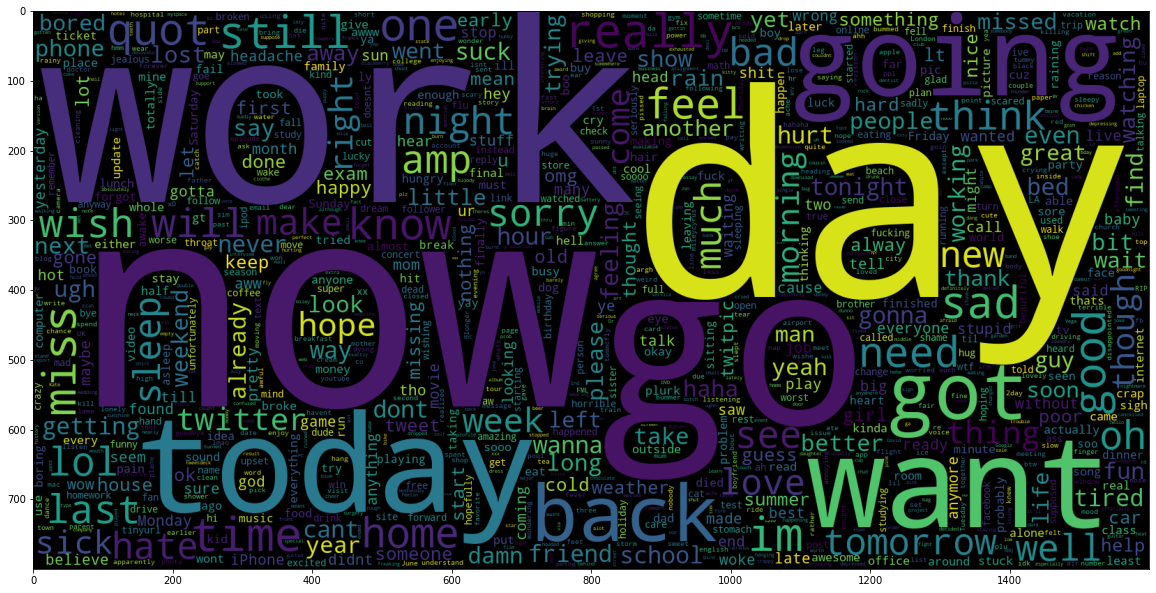

In [ ]:
# Wordcloud on Negative data
X = df.text.copy()
y = df.sentiment.copy()
data_neg = X[y==0]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

# Data Preprocessing

In [ ]:
# Codes for preprocessing
"""Remove HTML Tags, URL(including image urls), Mentions and Hashtags"""

def to_lower(df, columns = ['text']):
    for col in columns:
        df[col] = df[col].str.lower()
    return df
# pickle.dump(xgb, open('../models/74-xgb.pkl', 'wb'))

def replace_emojis(df, columns= ['text']):
    emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
    for col in columns:
        for emoji in emojis.keys():
                df['text'] = df['text'].replace(emoji, emojis[emoji])
    return df

def filter_html_tags(df, columns = ['text']):
    for col in columns:
        df[col] = df[col].apply(lambda x: re.split('<.*?>','' ,str(x)))
    return df

def filter_url(df, columns = ['text']):
    for col in columns:
        df[col] = df[col].apply(lambda x: re.sub(r'https?://\S+|www\.\S+| http?://\S+','', str(x)))
    return df

def filter_mentions_hashtags(df, columns = ['text']):
    for col in columns:
        df[col] = df[col].apply(lambda x: re.sub(r'\@\S+|\#', '', str(x)))
    return df

def lemmatization(df, columns = ['text']):
    lemmatizer = WordNetLemmatizer()
    for col in columns:
        df[col] = df[col].apply(lambda x: [lemmatizer.lemmatize(str(val)) for val in x if len(x) > 1])
    return df

def stemming(df, columns = ['text']):
    pstemmer = PorterStemmer()
    for col in columns:
        # df[col] = df[col].apply(lambda x: " ".join(nltk.PorterStemmer().stem(str(text)) for text in x.split()))
        df[col] = df[col].apply(lambda word_list: [pstemmer.stem(x) for x in word_list if len(x) > 1])
    return df

def filter_stopwords(df, columns = ['text']):
    stop_words = set(stopwords.words('english'))
    stop_words
    for col in columns:
        df[col] = df[col].apply(lambda x: ' '.join(x for x in str(x).split() if x not in stop_words and len(x)>2))
    return df

def remove_punctuation(df, columns = ['text']):
    for col in columns:
        df[col] = df[col].str.translate(str.maketrans('', '', string.punctuation))
    return df

from nltk.tokenize import word_tokenize, TweetTokenizer
def make_tokens(df, columns = ['text']):
    tt = TweetTokenizer()
    for col in columns:
        df[col] = df[col].apply(tt.tokenize)
    return df



def preprocess(df, columns = ['text']):
    df = to_lower(df,columns)
    # df = replace_emojis(df, columns)
    df = filter_url(df, columns= columns)
    df = filter_mentions_hashtags(df, columns= columns)
    df = remove_punctuation(df, columns= columns)
    df = filter_stopwords(df, columns= columns)
    df = make_tokens(df, columns = columns)
    df = stemming(df, columns= columns)
    df = lemmatization(df,columns= columns)

    return df


Initial preprocessing of the dataset

In [ ]:
df = preprocess(df)
df.text.head()
# Processing time : ~14 mins(PC)

0    [awww, that, bummer, shoulda, got, david, carr...
1    [upset, cant, updat, facebook, text, might, cr...
2    [dive, mani, time, ball, manag, save, rest, bo...
3               [whole, bodi, feel, itchi, like, fire]
4                              [behav, mad, cant, see]
Name: text, dtype: object

In [ ]:
# Joining the list to value
df['final_text'] = df['text'].apply(lambda x: ' '.join(x))
df = df[df['final_text'].str.len() > 0]
selected_features = df[['sentiment','final_text']].copy()
X = selected_features['final_text']
y = selected_features['sentiment']

EDA on preprocessed dataset

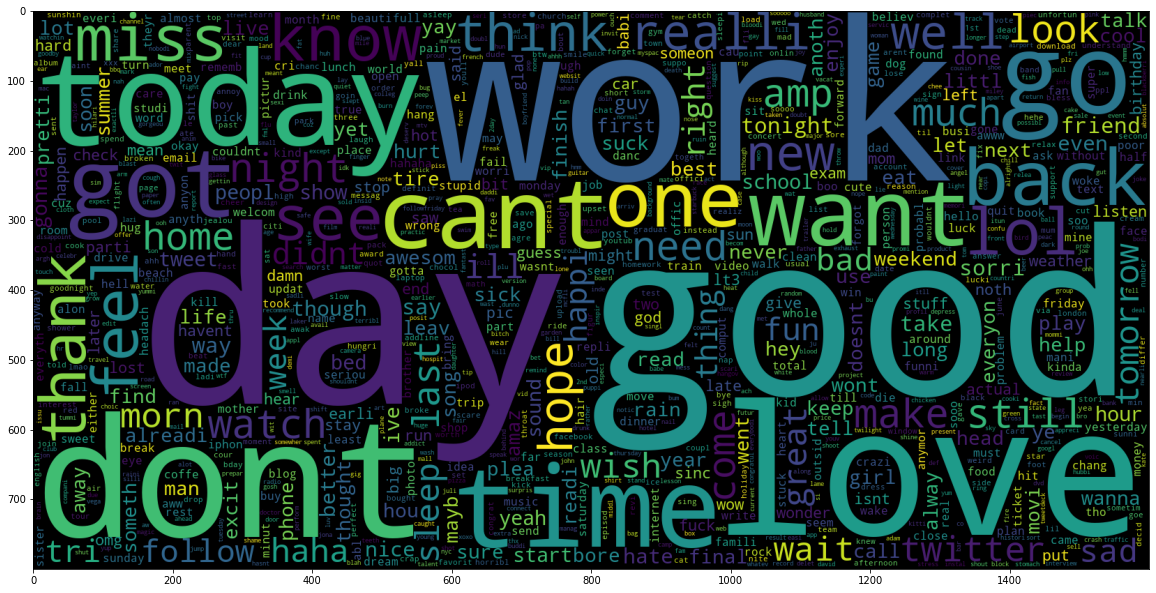

In [ ]:
# Wordcloud generation
data_neg = X
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

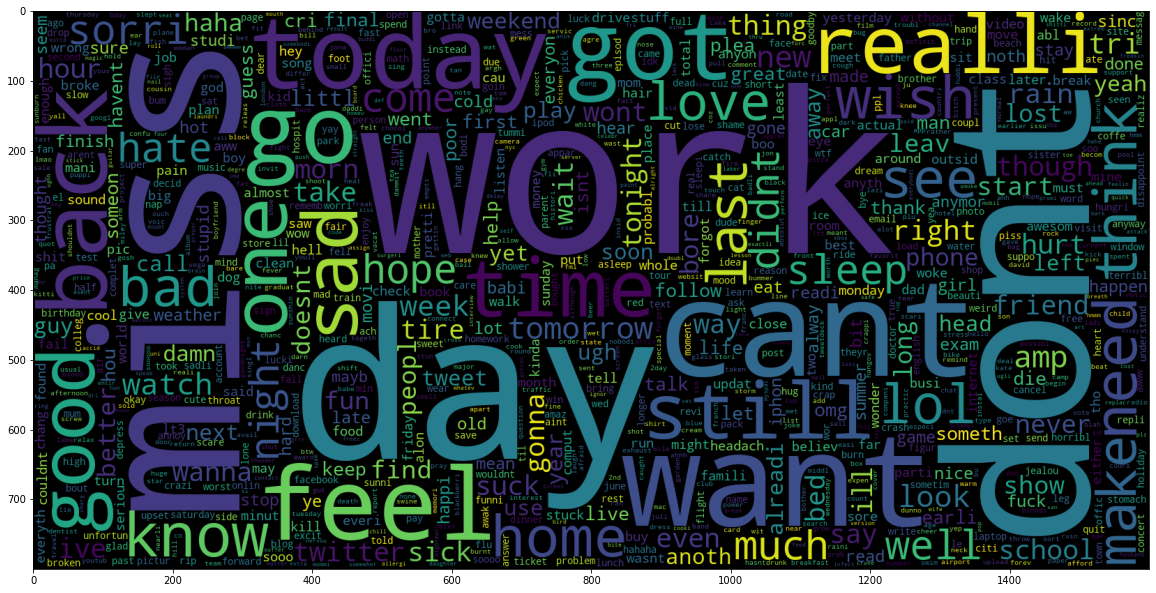

In [ ]:
data_neg = X[y == 0]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

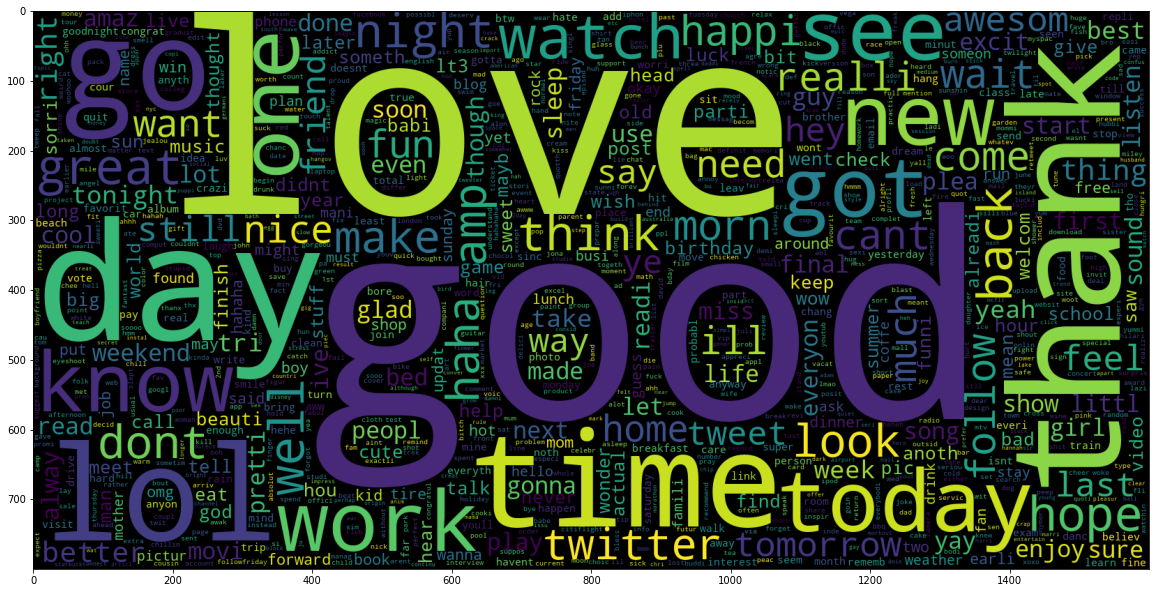

In [ ]:
data_neg = X[y == 4]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [ ]:
text_len = df['final_text'].str.len()
txt_mean = text_len.mean()
txt_max = text_len.max()
txt_min = text_len.min()
print("Mean length of the tweets is:",txt_mean)
print("Max length of the tweets is:",txt_max)
print("Min length of the tweets is:",txt_min)

Mean length of the tweets is: 39.74946420190854
Max length of the tweets is: 165
Min length of the tweets is: 4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534160 entries, 0 to 1599999
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   sentiment   1534160 non-null  int64 
 1   id          1534160 non-null  int64 
 2   date        1534160 non-null  object
 3   query       1534160 non-null  object
 4   user        1534160 non-null  object
 5   text        1534160 non-null  object
 6   final_text  1534160 non-null  object
dtypes: int64(2), object(5)
memory usage: 93.6+ MB


In [ ]:
# Validating if the longer words contain accented letters
longer_texts = df[df['final_text'].str.len() > 100]
longer_texts.head()

sentiment          id                          date     query  \
279           0  1467881373  Mon Apr 06 22:38:18 PDT 2009  NO_QUERY   
1767          0  1468228123  Tue Apr 07 00:25:08 PDT 2009  NO_QUERY   
2487          0  1468387095  Tue Apr 07 01:21:25 PDT 2009  NO_QUERY   
3249          0  1468552168  Tue Apr 07 02:22:04 PDT 2009  NO_QUERY   
4196          0  1468765260  Tue Apr 07 03:36:54 PDT 2009  NO_QUERY   

                 user                                               text  \
279      ForzaRagazza  [whing, clientampboss, dont, understand, engli...   
1767         Rainuryn  [tk, quottapauingquot, croissant, tuna, know, ...   
2487       Puffinhead  [flat, today, didnt, get, everythin, done, amp...   
3249           mars__  [red, jaguar, blue, barracuda, green, monkey, ...   
4196  nicolemissnikki  [mornin, babe, hella, pissedhungri, food, sinc...   

                                             final_text  
279   whing clientampboss dont understand english we...  
1767  tk quottapauingquot croissant tuna know dat iv...  
2487  flat today didnt get everythin done amp endur ...  
3249  red jaguar blue barracuda green monkey orang i...  
4196  mornin babe hella pissedhungri food sinc 9pm f...

Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=1000)



In [ ]:

tf = TfidfVectorizer(ngram_range= (1,3), max_features = 500000)
X_train = tf.fit_transform(X_train)
X_test = tf.transform(X_test)

In [ ]:
pickle.dump(tf, open('tf_july_10.pkl', 'wb'))

# Model Selection

Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
accuracy = {}
f1 = {}
conf_matrix={}

In [ ]:
y_pred_lr = lr.predict(X_test)
accuracy['lr'] = accuracy_score(y_test, y_pred_lr)
f1['lr'] = f1_score(y_test, y_pred_lr, pos_label = 4)

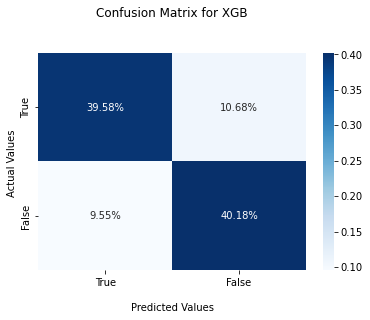

In [ ]:
def plot_conf(y_test, y_pred, key ):

  conf_matrix[key] = confusion_matrix(y_test, y_pred)
  ax = sns.heatmap(conf_matrix[key]/np.sum(conf_matrix[key]), annot=True, 
              fmt='.2%', cmap='Blues')
  ax.set_title('Confusion Matrix for ', key);
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['True','False'])
  ax.yaxis.set_ticklabels(['True','False'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()
plot_conf(y_test, y_pred_lr, 'lr')

Multinomial NB

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
y_pred_mnb = mnb.predict(X_test)
accuracy['mnb'] = accuracy_score(y_test, y_pred_mnb)
f1['mnb'] = f1_score(y_test, y_pred_mnb, pos_label = 4)
print(accuracy['mnb'], f1['mnb'])

0.7807421216387687 0.7792123117584383


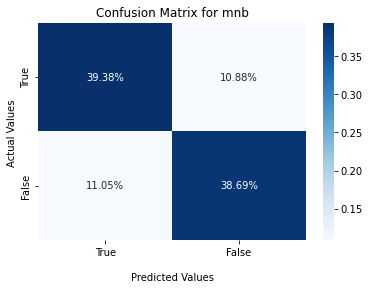

In [ ]:
def plot_conf(y_test, y_pred, key ):

  conf_matrix[key] = confusion_matrix(y_test, y_pred)
  ax = sns.heatmap(conf_matrix[key]/np.sum(conf_matrix[key]), annot=True, 
              fmt='.2%', cmap='Blues')
  ax.set_title('Confusion Matrix for '+ key);
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['True','False'])
  ax.yaxis.set_ticklabels(['True','False'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()
plot_conf(y_test, y_pred_mnb, 'mnb')

XGBoost

In [ ]:
# xgb = XGBClassifier()
# xgb.fit(X_train, y_train)

In [ ]:
# sys.path.append('../')
# xgb_val = pickle.load(open('/content/74-xgb.pkl', 'rb'))
# xgb_val._booster.save_model('xgb.model')
# xgb = XGBClassifier()
# xgb.load_model('xgb_val')
# xgb

In [ ]:
# y_pred_xgb = xgb.predict(X_test)
# accuracy['xgb'] = accuracy_score(y_test, y_pred_xgb)
# f1['xgb'] = f1_score(y_test, y_pred_xgb, pos_label = 4)
# print(accuracy['xgb'], f1['xgb'])

In [ ]:
# conf_matrix['xgb'] = confusion_matrix(y_test, y_pred_xgb)
# ax = sns.heatmap(conf_matrix['xgb']/np.sum(conf_matrix['xgb']), annot=True, 
#             fmt='.2%', cmap='Blues')
# ax.set_title('Confusion Matrix for'+key);
# ax.set_xlabel('\nPredicted Values')
# ax.set_ylabel('Actual Values ');

# ## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['True','False'])
# ax.yaxis.set_ticklabels(['True','False'])

# ## Display the visualization of the Confusion Matrix.
# plt.show()


# Final Model : LogisticRegression

Hyper Parameter Tuning

In [ ]:
# hyperparameter tuning
logModel = LogisticRegression()
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    # 'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','sag','saga'],
    'max_iter' : [2000,]
    }
]
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_v,y_v)


Selection(Saga)

In [ ]:
# Only tuning saga
# hyperparameter tuning
logModel = LogisticRegression()
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    # 'C' : np.logspace(-4, 4, 20),
     'l1_ratio': [ 0.2, 0.5, 0.7],
    'solver' : ['saga'],
    'max_iter' : [2000]
    }
]
from sklearn.model_selection import GridSearchCV
clf_sag = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_clf = clf_sag.fit(X_v,y_v)
best_clf.best_estimator_


In [ ]:
# Best Estimator From Saga
m = LogisticRegression(l1_ratio=0.5, max_iter=2000, solver='saga', penalty = 'elasticnet')
m.fit(X_train, y_train)

In [ ]:
y_pred_saga =m.predict(X_test)

In [ ]:
def plot_conf(y_test, y_pred, key ):

  conf_matrix[key] = confusion_matrix(y_test, y_pred)
  ax = sns.heatmap(conf_matrix[key]/np.sum(conf_matrix[key]), annot=True, 
              fmt='.2%', cmap='Blues')
  ax.set_title('Confusion Matrix for'+key);
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['True','False'])
  ax.yaxis.set_ticklabels(['True','False'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()
plot_conf(y_test, y_pred_saga, 'saga')

Selection(Lbfgs with l2 penalty)

In [ ]:
lbfgs = LogisticRegression( max_iter=2000, penalty = 'l2')
lbfgs.fit(X_train, y_train)


LogisticRegression(max_iter=2000)

In [ ]:
y_pred_lbfgs =lbfgs.predict(X_test)
score_lbfgs = lbfgs.score(X_train, y_train)
accuracy['lbfgs'] = accuracy_score(y_test, y_pred_lbfgs)
f1['lbfgs'] = f1_score(y_test, y_pred_lbfgs, pos_label =4)
print(accuracy['lbfgs'], f1['lbfgs'], score_lbfgs)

0.7976808155603066 0.7988846724535262 0.8384132033164728


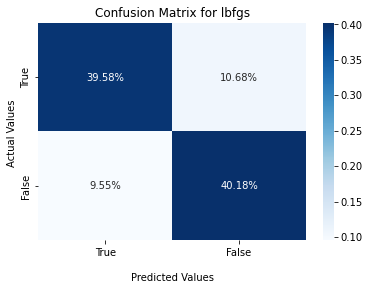

In [ ]:
def plot_conf(y_test, y_pred, key ):

  conf_matrix[key] = confusion_matrix(y_test, y_pred)
  ax = sns.heatmap(conf_matrix[key]/np.sum(conf_matrix[key]), annot=True, 
              fmt='.2%', cmap='Blues')
  ax.set_title('Confusion Matrix for '+key );
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['True','False'])
  ax.yaxis.set_ticklabels(['True','False'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()
plot_conf(y_test, y_pred_lbfgs, 'lbfgs')

# Undersampling

In [ ]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X, y, test_size=0.6, stratify = y, random_state=1000)

In [ ]:
tf_under = TfidfVectorizer(ngram_range= (1,3), max_features = 500000)
X_train_under = tf_under.fit_transform(X_train_under)
# X_test_under = tf.transform(X_test_under)

In [ ]:
X_train_vali, X_test_vali, y_train_vali, y_test_vali = train_test_split(X_test_under, y_test_under, test_size=0.4, stratify = y_test_under, random_state=1000)

In [ ]:
lbfgs_under = LogisticRegression( max_iter=2000, penalty = 'l2')
lbfgs_under.fit(X_train_under, y_train_under)

LogisticRegression(max_iter=2000)

In [ ]:
X_train_vali = tf_under.transform(X_train_vali)
y_pred_under = lbfgs_under.predict(X_train_vali)

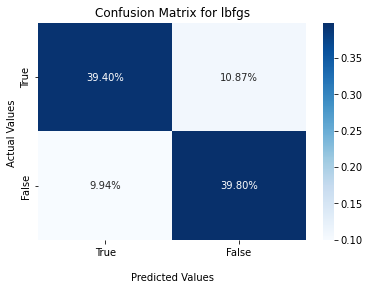

In [ ]:
def plot_conf(y_test, y_pred, key ):

  conf_matrix[key] = confusion_matrix(y_test, y_pred)
  ax = sns.heatmap(conf_matrix[key]/np.sum(conf_matrix[key]), annot=True, 
              fmt='.2%', cmap='Blues')
  ax.set_title('Confusion Matrix for '+key );
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['True','False'])
  ax.yaxis.set_ticklabels(['True','False'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()
plot_conf(y_train_vali, y_pred_under, 'lbfgs')

In [ ]:
X_test_vali = tf_under.transform(X_test_vali)
y_pred_test_vali = lbfgs_under.predict(X_test_vali)

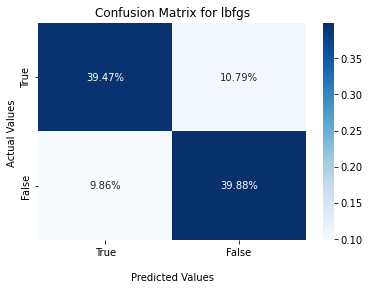

In [ ]:
def plot_conf(y_test, y_pred, key ):

  conf_matrix[key] = confusion_matrix(y_test, y_pred)
  ax = sns.heatmap(conf_matrix[key]/np.sum(conf_matrix[key]), annot=True, 
              fmt='.2%', cmap='Blues')
  ax.set_title('Confusion Matrix for '+key );
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['True','False'])
  ax.yaxis.set_ticklabels(['True','False'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()
plot_conf(y_test_vali, y_pred_test_vali, 'lbfgs')